**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1eXyPQC6SagHzpuBRK6Jo_x3TV79dvA6J?usp=sharing)

2. Практика


# Методы работы с сохранением / загрузкой весов и архитектуры модели нейронной сети

Для формирования модели нейронной сети создайте пустой контейнер **model** - экземпляр класса **Sequential**. Он содержит все методы класса, четыре из которых помогают сохранять и загружать как веса модели, так и полную архитектуру модели.

Часто нейронная сеть долго обучается, и чтобы не начинать все заново, можно сохранять веса модели или всю модель на промежуточных этапах. Это дает возможность в любой момент приостановить обучение, а затем продолжить с момента сохранения.

Если вы обучили сеть до требуемого уровня и хотите использовать ее в рабочем проекте, то можете записать финальную модель в файл после обучения.

---
Разница между ***сохранением модели*** `model.save()` и ***сохранением весов модели*** `model.save_weights()` заключается в том, что именно будет сохранено и как это можно использовать потом:
* ***сохранение весов модели*** `model.save_weights()` сохраняет в файл только значения весов модели, но не ее архитектуру (слои, нейроны, активации). Поэтому для использования сохраненных весов необходимо пересоздать архитектуру модели, загрузить в нее веса, скомпилировать, и только после этого можно использовать модель. Такой метод удобен, если модель не меняется, и нужно сохранить лучший результат или вернуться к более раннему этапу обучения модели.
* ***сохранение модели*** `model.save()` сохраняет модель полностью вместе с ее архитектурой, весами, состоянием оптимизатора и прочими параметрами. Для использования достаточно только загрузить модель. Этот метод удобен при поиске оптимальной архитектуры нейронной сети. Если сохранять только веса модели, то можно потерять информацию о лучшей ее архитектуре в процессе поиска.

Для примера вы создадите элементарную модель, на вход подадите случайные данные и попробуете два варианта сохранения.

In [41]:
# Загрузка библиотек

from tensorflow.keras.layers import Dense      
from tensorflow.keras import Sequential       
import matplotlib.pyplot as plt         
import numpy as np                   

In [ ]:
# Генерация случайных данных с размером пакета 20

X_train = np.random.random(size=(20, 8))   # Создание массива со случайными элементами формой (20, 8)
Y_train = np.random.random(size=(20, 1))   # Создание массива со случайными элементами формой (20, 1)

print(X_train.shape, Y_train.shape)        # Вывод на экран формы массивов

In [ ]:
# Сборка слоев в простую модель

model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))   

Проверьте форму входных данных и архитектуру модели:

In [ ]:
print(f'Форма входных данных: {model.input_shape}\n\n')

model.summary()

Обучите модель на случайных данных в течение нескольких эпох:

In [ ]:
# Компиляция и обучение модели

model.compile(loss='binary_crossentropy')
model.fit(X_train, Y_train, epochs=3)

## Сохранение только весов или модели полностью

Важно определиться, в какую директорию вы сохраните файл с весами модели:
- если вы укажете просто имя файла с расширением **.h5** (общепринятое для моделей и весов Keras), файл сохранится в дереве файлов и будет жить, пока активна текущая сессия Colab. Не самый лучший вариант: любой сбой системы и перезапуск лишат вас результатов проделанной работы.
- вы можете сохранить модель на своем google-диске. Для этого нужно подключить google-диск к colab, а затем выполнить сохранение с указанием полного пути к файлу с правильным маршрутом к google-диску.

Для примера воспользуемся здесь первым вариантом.


In [ ]:
# Имя и желаемый путь к будущему файлу

path_weight = 'weights.h5' 

Используйте методы объекта-модели для сохранения:

In [ ]:
# сохранение весов модели

model.save_weights(path_weight) 

In [ ]:
# сохранение архитектуры модели и ее весов

model.save('model.h5') 

Проверьте в дереве файлов, что все сохранилось как надо:

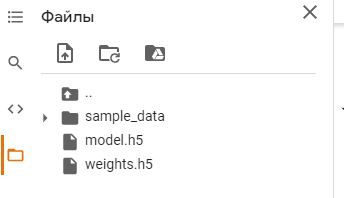

## Загрузка только весов или модели полностью

Чтобы было куда загружать веса, нужно сначала создать модель такой же архитектуры.


In [ ]:
model.load_weights(path_weight)  # загрузка весов
print('Веса загружены!')

Веса загружены!


Для загрузки модели целиком импортируйте функцию `load_model()` из модуля **tensorflow.keras.models**. Эта функция принимает в качестве аргумента путь к файлу, а возвращает загруженную модель:

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('model.h5') 
print('Модель и веса загружены!')

Модель и веса загружены!


Убедитесь, что архитектура модели восстановлена полностью:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                108       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________


Готовую модель можно запускать на центральном процессоре **CPU**, что требует меньших ресурсов. Графический ускоритель **GPU** используется лишь для обучения.


# Создание сверточной нейросети и ее сохранение 

Рассмотрим создание модели и сохранение ее весов и архитектуры на более сложном примере. Это сверточная сеть для классификации стандартного набора **Cifar10**.

---

**Важно!** Для ускорения обучения модели стоит переключиться на **GPU** в верхнем меню Colab: 

    Среда выполнения --> Сменить среду выполнения --> Аппаратный ускоритель

---

Начните с загрузки базы изображений и ее конвертации в нужный формат:

In [ ]:
from tensorflow.keras.datasets import cifar10  

# Загрузка cifar10
(x_train10, y_train10), (x_test10, y_test10) = cifar10.load_data()

170508288/170498071 [==============================] - 12s 0us/step


In [ ]:
# Размер изображения 32 x 32, 3 канала (цветное)

x_train10.shape 

(50000, 32, 32, 3)

In [42]:
# Определение названий классов в порядке, установленном в описании набора данных

classes = ['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

In [ ]:
# Нормирование изображений

x_train10 = x_train10 / 255.
x_test10 = x_test10 / 255.

In [ ]:
# Перевод меток класса y_train и y_test в формат one hot encoding

from tensorflow.keras import utils

# Число категорий в to_categorical() можно не указывать - инструмент определит его по данным
y_train10 = utils.to_categorical(y_train10)
y_test10 = utils.to_categorical(y_test10)

In [ ]:
# Проверка формы получившихся выборок

print(x_train10.shape)
print(x_test10.shape)
print(y_train10.shape)
print(y_test10.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 10)
(10000, 10)


Задайте размер пакета:

In [ ]:
batch_size = 128 

Создайте архитектуру модели:

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

In [ ]:
model = Sequential()

model.add(BatchNormalization(input_shape=(32, 32, 3)))  
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) 

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

Проверьте созданную архитектуру модели:

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 32, 32, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 32)      

Скомпилируйте модель, задав оптимизатор, функцию ошибки и метрики для проверки. Затем обучите модель на подготовленных выборках и выведите график точности обучения:



---

**Обратите внимание**

Далее идет код обучения нейронной сети. Вы можете пропустить этот этап и перейти к ячейке загрузки весов модели

---



In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])

history = model.fit(x_train10, 
                    y_train10, 
                    batch_size=batch_size, 
                    epochs=100,
                    validation_data=(x_test10, y_test10),
                    verbose=1)

# Вывод графика точности обучения

import matplotlib.pyplot as plt # -------- отрисовка графиков

plt.plot(history.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Сохраните всю модель (архитектуру и веса) после обучения:

In [ ]:
# Сохранение обученной модели полностью (веса и архитектура) после всех эпох

model.save('model_fmr_all.h5')

**загрузка весов модели с сервера**

Если вы пропустили этап обучения модели, то можете загрузить веса модели с нашего сервера:

In [44]:
import gdown
# Загрузка датасета из облака
gdown.download('https://storage.googleapis.com/datasets_ai/Base/6_modules/model_fmr_all.h5', None, quiet=True)

'model_fmr_all.h5'

# Запуск готовой модели

Чтобы можно было воспользоваться результатами обучения нейронки, необходимо провести подготовительные работы. В этом помогут изученные ранее функции и модули.

Загрузите сохраненную модель в переменную **model**:

In [45]:
from tensorflow.keras.models import load_model

model = load_model('model_fmr_all.h5')

Подготовьте тестовую картинку для подачи в модель:

In [46]:
# Загрузка тестовых изображений 10 классов

import gdown
gdown.download('https://storage.googleapis.com/datasets_ai/Knowledge/test_images.zip', None, quiet=True)

'test_images.zip'

In [47]:
# Распаковка архива

!unzip -qo test_images.zip

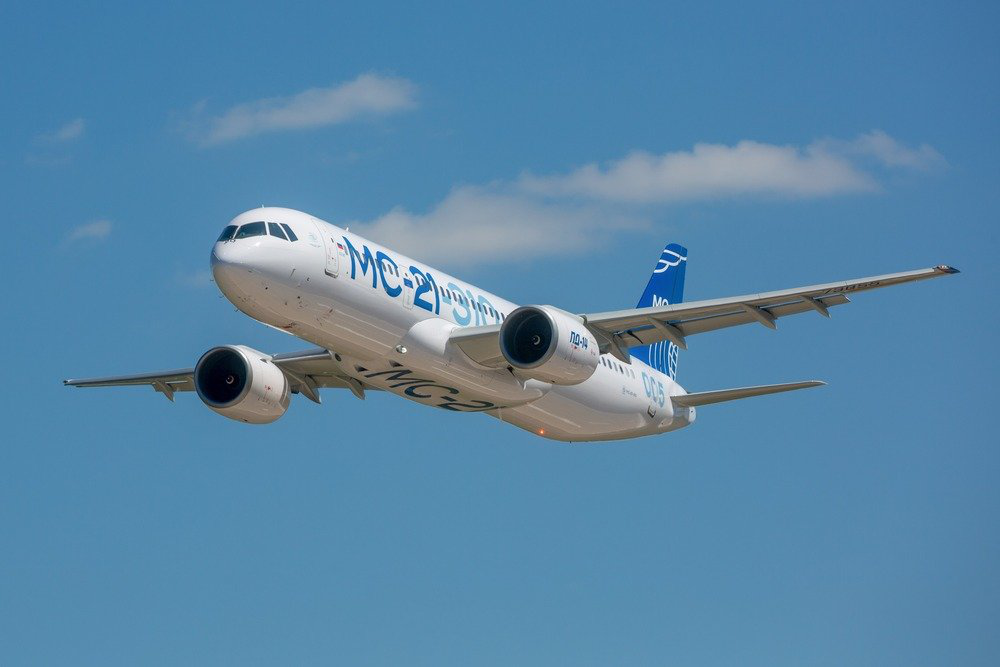

In [48]:
# Просмотр тестового изображения

from PIL import Image                                    

# Путь к файлу изображения
test_path = '/content/test_images/1.jpg'  
img = Image.open(test_path)

# Вывод изображения на экран 
display(img)   

Задайте требуемый для модели размер изображения:

In [49]:
# Требуемый для модели размер изображения
img_width, img_height = 32, 32            

Подготовьте тестовое изображение для подачи в модель.

Для наглядного расположения выводимой информации воспользуемся строковым методом `.format()`, задав выравнивание влево для имени класса и процентное представление вероятности принадлежности картинки к классу.

Для извлечения индексов класса применим встроенную функцию `enumerate()`, которая вернет не только элементы списка (имена классов), но и их индексы. Для всех классов это удобно сделать в цикле:
```
for i, cl in enumerate(classes):
```


---
Дополнительная информация: ([База знаний УИИ - «**Функция enumerate()**»](https://colab.research.google.com/drive/1r_5MjiYsrzqgk4hO8UpqKfQV1NDpdkoM?usp=sharing))

---

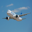

Результат распознавания:
самолет       100.00%
автомобиль     0.00%
птица          0.00%
кот            0.00%
олень          0.00%
собака         0.00%
лягушка        0.00%
лошадь         0.00%
корабль        0.00%
грузовик       0.00%

Изображен(а):  самолет


In [50]:
# Подготовка изображения для подачи в модель НС

import numpy as np

# Открытие картинки и изменение ее размера для соответсвия входу модели
img = Image.open(test_path).resize((img_width, img_height))

# Проверка результата
display(img) 

# Преобразование картинки в numpy-массив чисел с плавающей запятой и нормализация значений пикселей
image = np.array(img, dtype='float64') / 255.

# добавление оси для совпадения формы входа модели; получается батч из одного примера
image = np.expand_dims(image, axis=0)

# Распознавание изображения нейросетью

pred = model.predict(image)
print('Результат распознавания:')

for i, cl in enumerate(classes):    
    # Вывод предсказания сети для каждого класса
    print('{:<14s}{:6.2%}'.format(cl, pred[0, i]))
print()

# Вычисление индекса класса с максимальным значением вероятности и вывод имени класса
cls_image = np.argmax(model.predict(image))
print('Изображен(а): ', classes[cls_image])

# Запуск модели на демо-панели

Итак, у вас есть почти все необходимое для размещения модели нейронной сети на демо-панели. Осталась лишь пара штрихов.

Вначале создадим скрипт, который реализует распознавание изображения.

---

**ВАЖНЫЕ МОМЕНТЫ в задании главной функции скрипта:**

*   она должна иметь имя **predict**, так как сервер демо-панели будет вызывать функцию именно с таким именем;
*   она должна иметь первый обязательный аргумент **img_path** - путь к тестовому изображению на сервере демо-панели;
*   она должна иметь второй обязательный аргумент **model_path** - путь к модели на сервере демо-панели;
*   в скрипте должны быть импортированы все необходимые библиотеки для запуска модели, открытия и подготовки изображения.

---

В итоге скрипт может иметь примерно следующий вид:

In [51]:
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model

def predict(img_path='./test_image_1.jpg', model_path='./model_fmr_all.h5'):
    classes = {0: 'самолет',
               1: 'автомобиль',
               2: 'птица',
               3: 'кот',
               4: 'олень',
               5: 'собака',
               6: 'лягушка',
               7: 'лошадь',
               8: 'корабль',
               9: 'грузовик'}
    
    model = load_model(model_path)

    img_width, img_height = 32, 32

    img = Image.open(img_path).resize((img_height, img_width))
    image = np.array(img, dtype='float64') / 255

    image = np.expand_dims(image, axis=0)
    cls_image = np.argmax(model.predict(image))
    
    print(classes[cls_image])

Попробуйте вызвать функцию `predict()` в ячейке Colab:

In [52]:
predict(img_path='test_images/5.jpg', model_path='model_fmr_all.h5')

олень


На пятой картинке в тестовой папке дейстительно изображен **олень**:

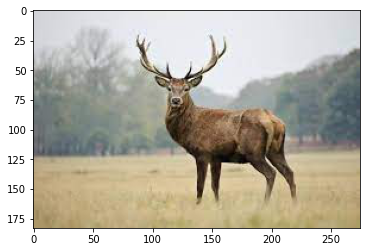

In [53]:
plt.imshow(Image.open('test_images/5.jpg'))
plt.show()

Теперь создадим текстовый файл с расширением **.py** и запишем в него созданный выше код (это и будет скрипт для демо-панели):

In [54]:
# Сохранение кода скрипта в переменной text_code

text_code = '''
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np

def predict(img_path='./test_image_1.jpg', model_path='./model_fmr_all.h5'):
    classes = {0: 'самолет',
               1: 'автомобиль',
               2: 'птица',
               3: 'кот',
               4: 'олень',
               5: 'собака',
               6: 'лягушка',
               7: 'лошадь',
               8: 'корабль',
               9: 'грузовик'}
    
    model = load_model(model_path)

    img_width, img_height = 32, 32

    img = Image.open(img_path).resize((img_height, img_width))
    image = np.array(img, dtype='float64') / 255

    image = np.expand_dims(image, axis=0)
    cls_image = np.argmax(model.predict(image))
    
    print(classes[cls_image])
    
'''

# Запись содержимого переменной в файл скрипта

with open('script.py', 'w') as f:  # Создание / открытие файла 
    f.write(text_code)             # Запись в файл значения переменной text_code

Следующим шагом подберем десять различных изображений, соответствующих классам датасета. Эти десять изображений будут отображаться на странице демо-панели в качестве пресетов. Загрузим их в директорию Colab под порядковыми номерами классов.

Вы можете взять абсолютно любые 10 изображений.

Здесь возьмем для этих целей файлы из тестовой папки:

In [55]:
# Библиотека для работы с файлами
from shutil import copyfile

for i in range(1, 11):
    copyfile(f'/content/test_images/{i}.jpg', f'/content/{i}.jpg')

В результате у вас должна получиться следующая структура файлов:

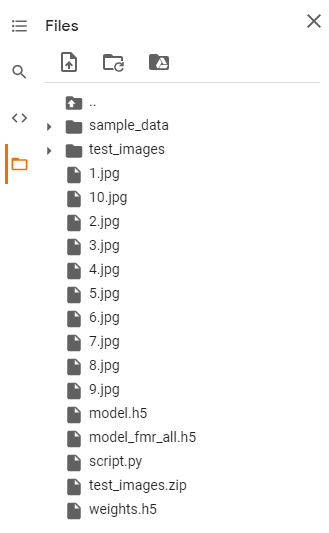

Далее создадим текстовый файл **label.txt** с именами классов, распознаваемых моделью. Алгоритм аналогичный: сначала создаем текстовую переменную с именами классов, затем записываем текст в файл:

In [56]:
label_txt = '''

самолет
автомобиль
птица
кот
олень
собака
лягушка
лошадь
корабль
грузовик

'''

with open('label.txt', 'w') as f:  # Создание / открытие файла 
    f.write(label_txt.strip())     # Запись в файл значения переменной

Осталось упаковать все файлы в один архив для отправки на сервер. 

Это можно сделать вручную; в ячейке ниже показано, как процесс может быть запрограммирован на **Python**.

---

**Важно!** Перед запуском следующей ячейки кода убедитесь, что все необходимые файлы присутствуют в каталоге **/content**!
- сохраненная модель **model_fmr_all.h5**;
- скрипт **script.py** с функцией `predict()`;
- текстовый файл **label.txt** с именами классов;
- **10** изображений.

---


In [57]:
import os
from zipfile import ZipFile as Zip             # Модуль для работы с zip-архивами

# Список всех файлов
integrate_files = ['model_fmr_all.h5', 'script.py', 'label.txt', *[f'{i}.jpg' for i in range(1, 11)]]

zipArchive = Zip('/content/archive.zip', 'w')  # Открытие файла, если такого не существует - будет создан новый

for file in integrate_files:                   # Для всех всем нужных файлов:
    if os.path.exists(file):                   # Если файл существует,
        zipArchive.write(file)                 # то добавление его в архив
    else:
        print(f'Файл {file} отсутствует!')     # иначе вывод на экран названия отсутствующего файла

zipArchive.close()                             # В финале архив следует закрыть, как и обычный файл

Скачайте готовый Zip-архив себе на компьютер, чтобы далее отправить его на сервер:

In [58]:
from google.colab import files               # Функция для скачивания данных на локальный компьютер

files.download(filename='archive.zip')       # Скачивание готового архива

print('Архив загружен')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Архив загружен


## Загрузка собранного архива на страницу распознавания



Перейдите по ссылке:

[Загрузить архив на демо-панель](https://srv2.demo.neural-university.ru/autodeploy.html)

1.   На странице введите свое *Имя* и *Фамилию* в соответствующие поля;
2.   Нажмите на кнопку **Выберите файл** и выберите архив на своем компьютере;
3.   Нажмите на кнопку **Загрузить**;
4.   После завершения загрузки откроется ваша персональная страница с работющей моделью нейронной сети!





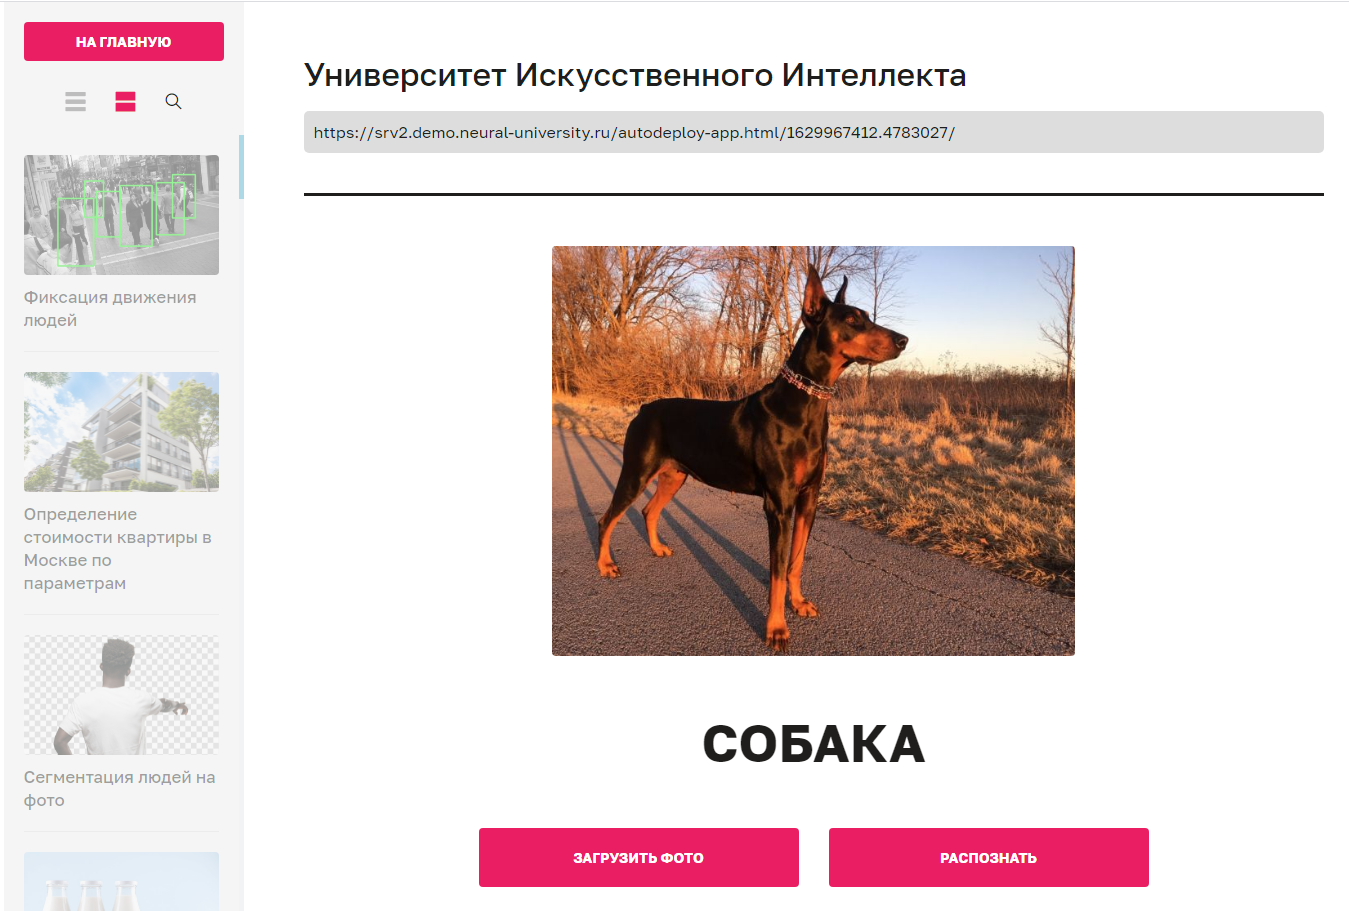

Вы можете проверить работу своей мадели на готовых пресетах (10 изображений), а можете загрузить любую произвольную картинку с помощью кнопки **"Загрузить фото"**.

---

**Важно**! Созданные вами страницы будут доступны на протяжении двух дней, после чего будет автоматически удалены.

---

**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1eXyPQC6SagHzpuBRK6Jo_x3TV79dvA6J?usp=sharing)

2. Практика
